# Unbalanced Data

This notebook explores learning with unbalanced classes, and the use of class_weights to help ameliorate the issue.

First, we construct an artificial neural network that we will use to try to learn the XOR task. 

In [1]:
import conx as cx

Using TensorFlow backend.
Conx, version 3.6.2


In [2]:
net = cx.Network("XOR", 2, 2, 1, activation="sigmoid")
net.compile(error="mse", optimizer="sgd", lr=0.1, momentum=0.1)

In [3]:
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2)                 0         
_________________________________________________________________
hidden (Dense)               (None, 2)                 6         
_________________________________________________________________
output (Dense)               (None, 1)                 3         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


We define a `make_dataset` function that make the standard XOR dataset, or, it can also make a version that has one of the four patterns over-represented by 100:

In [5]:
def make_dataset(unbalanced=False):
    dataset = [
        [[0, 0], [0], ["0,0"]],
        [[1, 0], [1], ["1,0"]],
        [[1, 1], [0], ["1,1"]],
        [[0, 1], [1], ["0,1"]],
    ]
    if unbalanced:
        for i in range(99):
            dataset.append([[0, 1], [1], ["0,1"]])
    return dataset

If we train it regularly, then it can often learn the task in about 10,000 epochs:

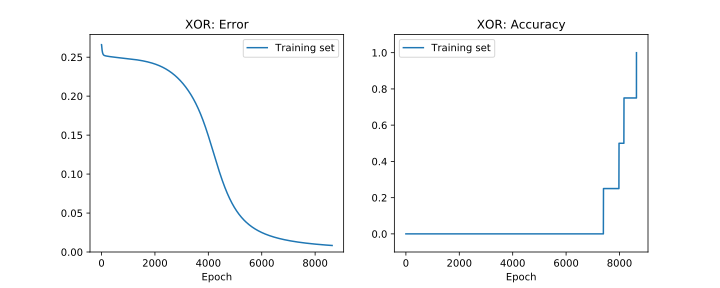

       |  Training |  Training 
Epochs |     Error |  Accuracy 
------ | --------- | --------- 
# 8636 |   0.00836 |   1.00000 


In [46]:
net.dataset.load(make_dataset())
net.reset()
net.train(15000, accuracy=1.0, report_rate=100)

Now, we try it with the unbalanced dataset. Usually, it can't learn this version within 15,000 epochs. It is just a hard problem.

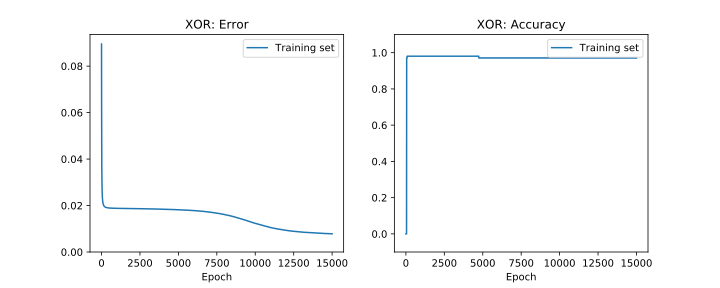

       |  Training |  Training 
Epochs |     Error |  Accuracy 
------ | --------- | --------- 
#15000 |   0.00784 |   0.97087 


In [47]:
net.dataset.load(make_dataset(unbalanced=True))
net.reset()
net.train(15000, accuracy=1.0, report_rate=100)

Now, we try the unbalanced dataset again, but this time we will give 100 times the weighting for those "samples" (e.g. patterns) that are under represented:

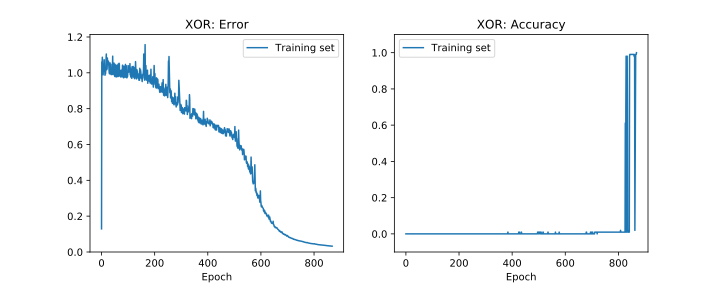

       |  Training |  Training 
Epochs |     Error |  Accuracy 
------ | --------- | --------- 
#  868 |   0.03248 |   1.00000 


In [27]:
net.dataset.load(make_dataset(unbalanced=True))
net.reset()
net.train(15000, accuracy=1.0, report_rate=100, sample_weight=cx.np.array([100, 100, 100] + ([1] * 100)))

Wow. That's interesting. It learns the task even faster than the balanced dataset. Why? How?

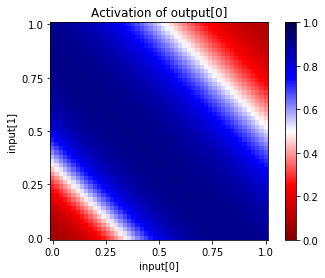

In [28]:
net.plot_activation_map()

There seem to be two points:

* the weight changes are balanced by the representation
* there is a focusing of the weight changes on those that can be learned quickly

Looking at the 100 x learning weight, that suggests that this should learn quickly:

In [52]:
net = cx.Network("XOR", 2, 2, 1, activation="sigmoid")
net.compile(error="mse", optimizer="sgd", lr=10.0, momentum=0.1)

And it does (I'm surprised... I had never tried a learning rate that large):

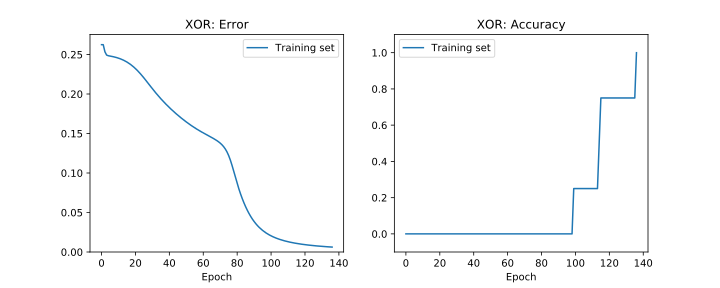

       |  Training |  Training 
Epochs |     Error |  Accuracy 
------ | --------- | --------- 
#  136 |   0.00623 |   1.00000 


In [53]:
net.dataset.load(make_dataset(unbalanced=False))
net.reset()
net.train(15000, accuracy=1.0, report_rate=100)

## Notes

The rest of this notebook are some notes about making a PatternWeights class that can dynamically adjust the weightings for each sample.

Keras's fit method can take `class_weight` and `sample_weight` keywords. However, `class_weight` is a "class" determined by target value(s) and so can't be used in this example, because there are two patterns that have the same output, but only one that is unbalanced.

In this implementation of PatternWeights, it recomputes the weighting every `recompute` epochs. It selects the one that is most wrong, and focuses attention on that one.

In [33]:
from sklearn.utils.extmath import softmax

class PatternWeights():
    def __init__(self, network, recompute):
        self.count = 0
        self.network = network
        self.recompute = recompute
        self.length = len(self.network.dataset.inputs)
    def __len__(self):
        return self.length
    def __getitem__(self, indices):
        if self.count % self.recompute == 0:
            diffs = cx.np.abs(self.network.model.predict(net.dataset._inputs) - self.network.dataset._targets)
            self.diffs = [1] * self.length
            self.diffs[cx.argmax([x[0] for x in softmax(diffs)[0].tolist()])] = self.length
        self.count += 1
        return [self.diffs[i] for i in indices]
    @property
    def shape(self):
        return (self.length,)
    @property
    def ndim(self):
        return 1

In [49]:
mylist = PatternWeights(net, 100)

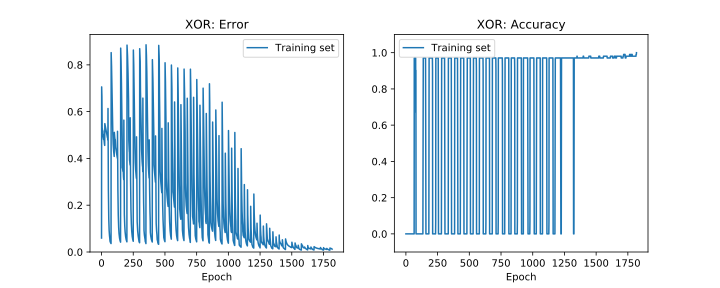

       |  Training |  Training 
Epochs |     Error |  Accuracy 
------ | --------- | --------- 
# 1818 |   0.01230 |   1.00000 


In [50]:
net.dataset.load(make_dataset(unbalanced=True))
net.reset()
net.train(15000, accuracy=1.0, report_rate=100, sample_weight=mylist)

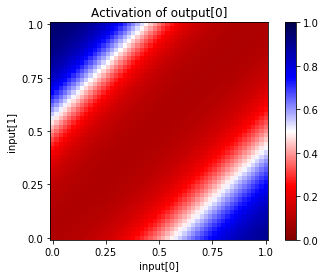

In [51]:
net.plot_activation_map()